In [1]:
# ---------------------------------------------------------
# CORREÇÃO PARA AUTORELOAD NO PYTHON 3.12 (Google Colab)
# Executar na primeira célula do notebook
# ---------------------------------------------------------
import sys
import importlib

# O Python 3.12 removeu o 'imp', mas o autoreload antigo precisa dele.
# Vamos criar um "falso" imp apontando para o importlib.
if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

# Agora sim, carregamos a extensão mágica
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================================
# 1. Setup do Ambiente
# ==========================================
from google.colab import drive
import sys
import os

# Montar Drive (opcional, se estiver salvando lá)
drive.mount('/content/drive')

# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/tabpfn-stab-tabkan

# Instalar dependências específicas
!pip install -q xgboost pykan

# Adicionar diretório atual ao path para importações funcionarem
sys.path.append('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'telecom-churn-project' already exists and is not an empty directory.
/content/telecom-churn-project
M	models/stab_model.py
Already on 'feature/tabpfn-stab-tabkan'
Your branch is behind 'origin/feature/tabpfn-stab-tabkan' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)


In [3]:
# !git fetch origin

# !git reset --hard feature/tabpfn-stab-tabkan

In [4]:
# ==========================================
# Célula para Baixar Dados (Kaggle)
# ==========================================
import kagglehub
import shutil
import os

print("⬇️ Baixando dataset do Kaggle...")
# Baixa a versão mais recente
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")

# Caminhos de destino
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"
dest_path = os.path.join(dest_dir, dest_file)

# Criar pasta se não existir
os.makedirs(dest_dir, exist_ok=True)

# O arquivo original geralmente vem com este nome:
source_file = os.path.join(path, "customer_churn_telecom_services.csv")

# Mover e renomear
if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...
Using Colab cache for faster access to the 'customers-churned-in-telecom-services' dataset.
📂 Dataset baixado em: /kaggle/input/customers-churned-in-telecom-services
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


In [5]:
# ==========================================
# 2. Executar Pipeline de Dados
# ==========================================
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [6]:
# ==========================================
# 3. Imports e Carregamento dos Dados
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Importando SUAS classes e funções
from models.stab_model import STabModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

# Carregar dados processados (gerados pelo prepare_data.py)
DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

# Helper simples para exibir métricas no notebook
def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando STabModel...
--- STabModel (Teste) ---
KS:        0.3835 (Threshold: 0.59)
AUROC:     0.7509
F1 Score:  0.5349


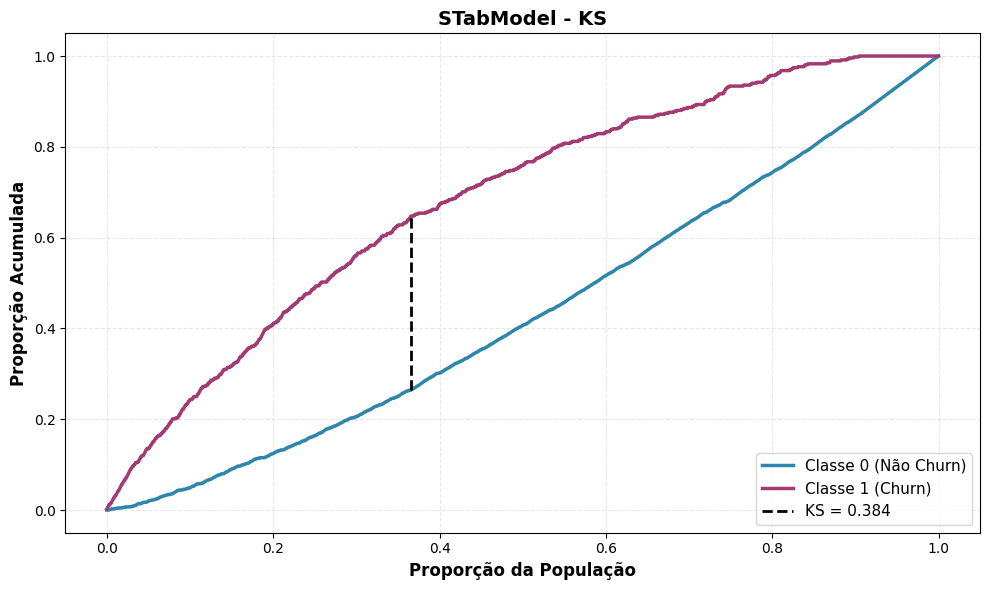

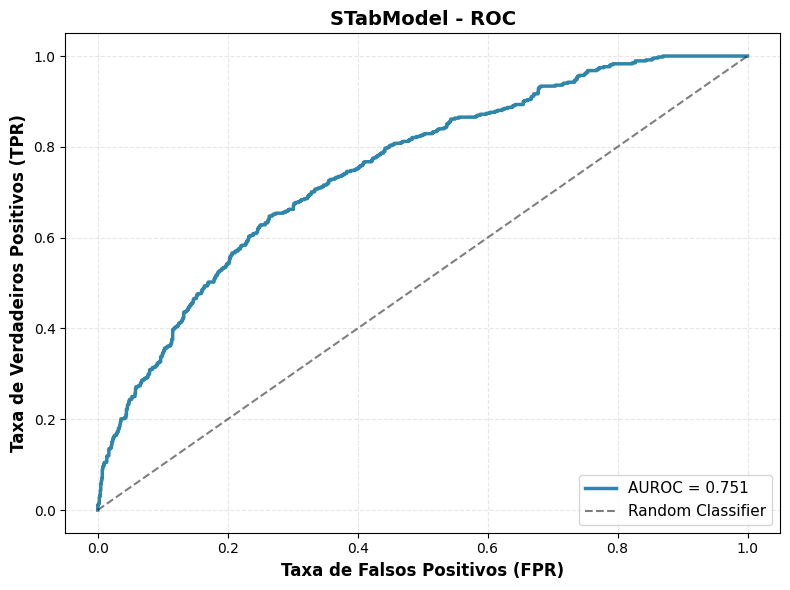

In [7]:
# ==========================================
# 4. Experimento: STabModel (PyTorch)
# ==========================================
print("🚀 Treinando STabModel...")


stab = STabModel(input_dim=X_train.shape[1], name="STab_Baseline")
stab.train(X_train, y_train, X_val, y_val)

# Avaliação no Teste
y_pred_stab = stab.predict_proba(X_test)
metrics_stab = calculate_all_metrics(y_test, y_pred_stab)

print_metrics("STabModel (Teste)", metrics_stab)

plot_ks_statistic(y_test, y_pred_stab, title="STabModel - KS")
plot_roc_curve(y_test, y_pred_stab, title="STabModel - ROC")
